In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import atmosentry
from atmosentry.meteoroid import Meteoroid

matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

Small impactors will typically fragment several times before either reaching the surface, or the total abaltion of their initial mass. We demonstrate this functionality below.

In [2]:
sim = atmosentry.Simulation()

In [3]:
# impactor material properties (bulk density, tensile strength, heat of ablation)
rho_imp = 0.6e3 # kg/m^3
eta_imp = 2.5e6 # J/kg
sigma_imp = 1e4 # Pa

theta0 = 45. * np.pi / 180. # impact angle (radians)
V0 = 20e3 # top-of-atmosphere impact velocity

R0 = 200 # initial radius
M0 = rho_imp * (4 * np.pi / 3) * (R0 ** 3) # initial mass

In [4]:
impactor = Meteoroid(x=0,
                     y=0,
                     z=100e3,
                     vx=-V0 * np.cos(theta0),
                     vy=0,
                     vz=-V0 * np.sin(theta0),
                     radius=R0,
                     mass=M0,
                     sigma=sigma_imp,
                     rho=rho_imp,
                     eta=eta_imp)

sim.impactor = impactor

sim.dt = 1e-3 # here you can set the maximum timestep of the simulation

sim.integrate()

We can now extract the trajectory of the impactor, and its child fragments genereated during atmospheric entry. The mass of these child fragments are randomly generated, and thus the results of this integration will vary each time.

In [5]:
x_imp, y_imp, z_imp = sim.impactor.state.x, sim.impactor.state.y, sim.impactor.state.z
vx_imp, vy_imp, vz_imp = sim.impactor.state.vx, sim.impactor.state.vy, sim.impactor.state.vz

vel_imp = np.sqrt(vx_imp ** 2 + vy_imp ** 2 + vz_imp ** 2)

radius_imp, mass_imp = sim.impactor.state.radius, sim.impactor.state.mass
dM_imp, dEkin_imp = sim.impactor.state.dM, sim.impactor.state.dEkin

if len(sim.fragments):
    
    print(f"The impactor fragmented into {len(sim.fragments)} bodies during atmospheric entry.\n")
    
    for fragment in sim.fragments:
        print(fragment)
    
else:
    print("The impactor did not fragment during atmospheric entry.")

The impactor fragmented into 2 bodies during atmospheric entry.



Here, we extract the key properties of the child fragments, which we will plot later in this notebook. 

In [6]:
fragments_data = {}

for i, fragment in enumerate(sim.fragments):
    
    fragments_data[i] = {
        "x": fragment.state.x,
        "y": fragment.state.y,
        "z": fragment.state.z,
        "vx": fragment.state.vx,
        "vy": fragment.state.vy,
        "vz": fragment.state.vz,
        "vel": np.sqrt(fragment.state.vx ** 2 + fragment.state.vy ** 2 + fragment.state.vz ** 2),
        "mass": fragment.state.mass,
        "radius": fragment.state.radius,
        "children": fragment.children, # this tells us whether a fragment undergoes a further fragmentation
        "KE": 0.5 * fragment.state.mass * (fragment.state.vx ** 2 + fragment.state.vy ** 2 + fragment.state.vz ** 2),
        "mass_loss": np.cumsum(fragment.state.dM),
        "energy_loss": np.cumsum(fragment.state.dEkin)
    }

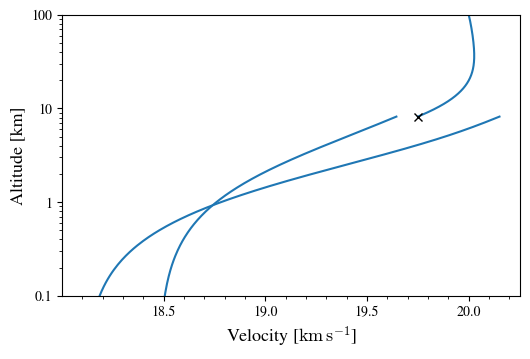

In [7]:
_ = plt.figure(figsize=(5.91, 3.65))

plt.plot(vel_imp / 1e3, z_imp / 1e3)
plt.plot(vel_imp[-1] / 1e3, z_imp[-1] / 1e3, 'x', color='k')

for counter in range(len(sim.fragments)):
    plt.plot(fragments_data[counter]["vel"] / 1e3, fragments_data[counter]["z"] / 1e3, color='tab:blue')

    if fragments_data[counter]["children"]:
        plt.plot(fragments_data[counter]["vel"][-1] / 1e3, fragments_data[counter]["z"][-1] / 1e3, 'x', color='k')

plt.yscale('log')

plt.ylim(1e-1, 1e2)
plt.yticks([0.1, 1, 10, 100], labels=[0.1, 1, 10, 100])

plt.xlabel(r'Velocity [${\rm km\,s}^{-1}$]', fontsize=13)
plt.ylabel(r'Altitude [km]', fontsize=13)

plt.minorticks_on()

plt.show()

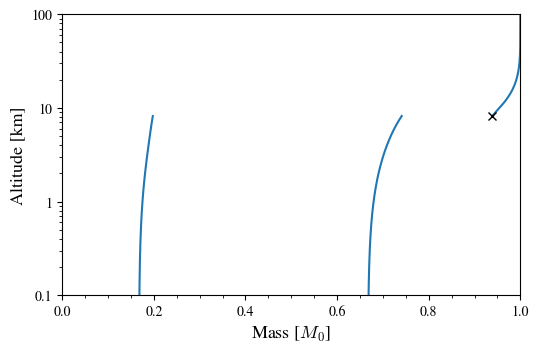

In [8]:
_ = plt.figure(figsize=(5.91, 3.65))

plt.plot(mass_imp / M0, z_imp / 1e3)
plt.plot(mass_imp[-1] / M0, z_imp[-1] / 1e3, 'x', color='k')

for counter in range(len(sim.fragments)):
    plt.plot(fragments_data[counter]["mass"] / M0, fragments_data[counter]["z"] / 1e3, color='tab:blue')

    if fragments_data[counter]["children"]:
        plt.plot(fragments_data[counter]["mass"][-1] / M0, fragments_data[counter]["z"][-1] / 1e3, 'x', color='k')

plt.yscale('log')

plt.xlim(0, 1)
plt.ylim(1e-1, 1e2)
plt.yticks([0.1, 1, 10, 100], labels=[0.1, 1, 10, 100])

plt.xlabel(r'Mass [$M_0$]', fontsize=13)
plt.ylabel(r'Altitude [km]', fontsize=13)

plt.minorticks_on()

plt.show()

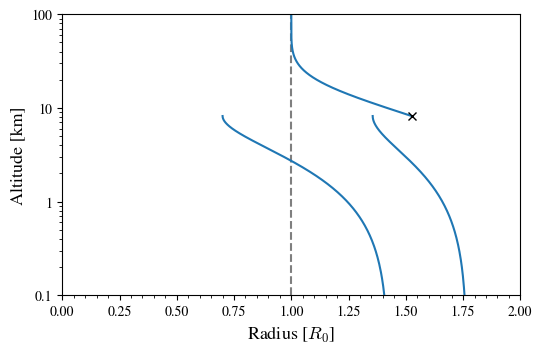

In [9]:
_ = plt.figure(figsize=(5.91, 3.65))

plt.plot(radius_imp / R0, z_imp / 1e3)
plt.plot(radius_imp[-1] / R0, z_imp[-1] / 1e3, 'x', color='k')

for counter in range(len(sim.fragments)):
    plt.plot(fragments_data[counter]["radius"] / R0, fragments_data[counter]["z"] / 1e3, color='tab:blue')

    if fragments_data[counter]["children"]:
        plt.plot(fragments_data[counter]["radius"][-1] / R0, fragments_data[counter]["z"][-1] / 1e3, 'x', color='k')

plt.axvline(1, color='tab:gray', ls='--', zorder=0)

plt.yscale('log')

plt.xlim(0, 2)
plt.ylim(1e-1, 1e2)
plt.yticks([0.1, 1, 10, 100], labels=[0.1, 1, 10, 100])

plt.xlabel(r'Radius [$R_0$]', fontsize=13)
plt.ylabel(r'Altitude [km]', fontsize=13)

plt.minorticks_on()

plt.show()

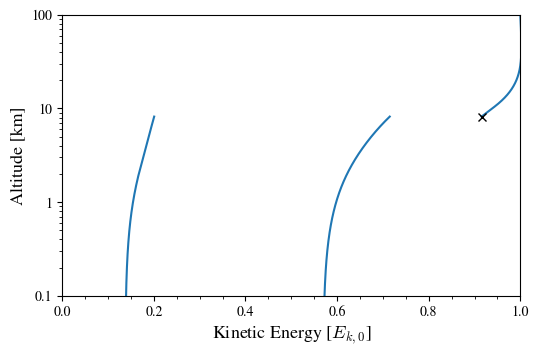

In [10]:
KE0 = 0.5 * M0 * (V0 ** 2)

_ = plt.figure(figsize=(5.91, 3.65))

plt.plot(0.5 * mass_imp * (vel_imp ** 2) / KE0, z_imp / 1e3)
plt.plot(0.5 * mass_imp[-1] * (vel_imp[-1] ** 2) / KE0, z_imp[-1] / 1e3, 'x', color='k')

for counter in range(len(sim.fragments)):

    plt.plot(fragments_data[counter]["KE"] / KE0, fragments_data[counter]["z"] / 1e3, color='tab:blue')

    if fragments_data[counter]["children"]:
        plt.plot(fragments_data[counter]["KE"][-1] / KE0, fragments_data[counter]["z"][-1] / 1e3, 'x', color='k')

plt.yscale('log')

plt.xlim(0, 1)
plt.ylim(1e-1, 1e2)
plt.yticks([0.1, 1, 10, 100], labels=[0.1, 1, 10, 100])

plt.xlabel(r'Kinetic Energy [$E_{k,0}$]', fontsize=13)
plt.ylabel(r'Altitude [km]', fontsize=13)

plt.minorticks_on()

plt.show()

In [11]:
def calc_combined_fragment_deposition(sim):
    """
    Docstring: need to combine contribution from contributions at constant altitude... (rewrite)
    """
    
    altitudes = np.linspace(0, 100e3, 10000)
    cumulative_energy_deposition = np.zeros_like(altitudes)
    cumulative_mass_deposition = np.zeros_like(altitudes)

    for j, h in enumerate(altitudes):
        cumulative_dE = 0.0
        cumulative_dM = 0.0

        cumulative_dE += np.sum(sim.impactor.state.dEkin[sim.impactor.state.z >= h])
        cumulative_dM += np.sum(sim.impactor.state.dM[sim.impactor.state.z >= h])

        for fragment in sim.fragments:
            cumulative_dE += np.sum(fragment.state.dEkin[fragment.state.z >= h])
            cumulative_dM += np.sum(fragment.state.dM[fragment.state.z >= h])
        
        cumulative_energy_deposition[j] = cumulative_dE
        cumulative_mass_deposition[j] = cumulative_dM
    
    return altitudes, cumulative_energy_deposition, cumulative_mass_deposition

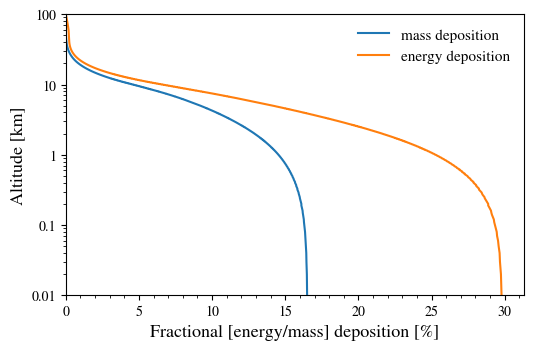

In [12]:
KE0 = 0.5 * M0 * (V0 ** 2)

altitudes, cumulative_energy_deposition, cumulative_mass_deposition = calc_combined_fragment_deposition(sim)

_ = plt.figure(figsize=(5.91, 3.65))

plt.plot(cumulative_mass_deposition / M0 * 100, altitudes / 1e3, label=r'mass deposition')
plt.plot(cumulative_energy_deposition / KE0 * 100, altitudes / 1e3, label=r'energy deposition')

plt.yscale('log')

plt.xlim(0, )
plt.ylim(1e-2, 1e2)
plt.yticks([0.01, 0.1, 1, 10, 100], labels=[0.01, 0.1, 1, 10, 100])

plt.xlabel(r'Fractional [energy/mass] deposition [%]', fontsize=13)
plt.ylabel(r'Altitude [km]', fontsize=13)

plt.minorticks_on()

plt.legend(frameon=False, fontsize=11)

plt.show()